In [1]:
using WordEmbeddings
using Training

In [3]:

data_dir = joinpath("data") #For local run from testing directory

test_filename = "text8_miniscule"
test_file = joinpath(data_dir, test_filename)


model_file = "models/text8_miniscule.model"

"models/text8_miniscule.model"

In [4]:
using Utils

In [ ]:
function test_sense_embedding(inputfile)

	embed = WordSenseEmbedding(30, random_inited, huffman_tree, subsampling = 0, iter=2, strength=0.4, force_minibatch_size=100)
	@time train(embed, inputfile)

    save(embed, model_file)
	embed
end


In [ ]:
Profile.clear()  # in case we have any previous profiling data
@profile test_sense_embedding(test_file)

In [ ]:
using ProfileView

ProfileView.view()

In [5]:
using SoftmaxClassifier

In [8]:
function test(fn)
    embed = restore(model_file)
    words = split(open(readstring,test_file,"r"))
    time_total = 0.0
    for ii in 10:length(words)-1000
        word = words[ii]
        !haskey(embed.codebook,word) && continue 
        context = [words[ii-5:ii-1]; words[ii+1:ii+5]]
        context = filter(w->haskey(embed.codebook,w),context)
        tic()
        fn(embed,word, context)
        time_total+=toq()
    end
    time_total
end


test (generic function with 1 method)

In [16]:
function WSD2{S<:AbstractString}(embed::WordEmbeddings.WordSenseEmbedding, word::AbstractString, context::AbstractVector{S})
    function prob_of_context{S<:AbstractString}(embed::GenWordEmbedding, context::AbstractVector{S}, input::Vector{Float32})
        total_logprob=0.0 #Work in logprob to avoid underflow, and get more stability
        for target_word in context
            # discard words not presenting in the classification tree
            haskey(embed.codebook, target_word) || continue
            node = embed.classification_tree      

            word_logprob = 0.0
            for code in embed.codebook[target_word]  
                word_logprob+=log(predict(node.data, input)[code])
                node = node.children[code]
            end
            total_logprob+=word_logprob
        end
        exp(total_logprob) #Going back out of the log domain is not required for external logic, but it is nice for clarity
    end
    
    
    sense_embeddings = embed.embedding[word]
    prob, most_likely_sense_id = findmax([prob_of_context(embed, context, input) for input in sense_embeddings])
    return most_likely_sense_id
end
gc()
@time test(WSD2)

  8.230742 seconds (3.71 M allocations: 332.649 MB, 0.94% gc time)


7.843321198000006

In [15]:
@fastmath function WSD3{S<:AbstractString}(embed::WordEmbeddings.WordSenseEmbedding, word::AbstractString, context::AbstractVector{S})
    function prob_of_context{S<:AbstractString}(embed::GenWordEmbedding, context::AbstractVector{S}, input::Vector{Float32})
        total_prob=0.0 #Work in logprob to avoid underflow, and get more stability
        @inbounds for target_word in context
            # discard words not presenting in the classification tree
            haskey(embed.codebook, target_word) || continue
            node = embed.classification_tree      

            word_prob = 0.0
            @inbounds for code in embed.codebook[target_word]  
                word_prob+=predict(node.data, input)[code]
                node = node.children[code]
            end
            total_prob*=word_prob
        end
        exp(total_prob) #Going back out of the log domain is not required for external logic, but it is nice for clarity
    end
    
    
    sense_embeddings = embed.embedding[word]
    prob, most_likely_sense_id = findmax([prob_of_context(embed, context, input) for input in sense_embeddings])
    return most_likely_sense_id
end
gc()
@time test(WSD3)

  7.967300 seconds (3.63 M allocations: 329.640 MB, 0.85% gc time)


7.697401563000001

In [ ]:
?softmax!

In [6]:
using StatsFuns
import SoftmaxClassifier.predict

In [21]:
@inbounds @inline function softmax2!{R<:AbstractFloat}(t::AbstractArray{R})
    u = max(t[1],t[2])
    @inbounds t[1] = exp(t[1] - u)
    @inbounds t[2] = exp(t[2] - u)
    @inbounds u = t[1]+t[2]
    @inbounds t[1]/=u
    @inbounds t[2]/=u
    t
end
@fastmath function predict{F<:AbstractFloat}(c::LinearClassifier, x::AbstractVector{F})
    t= F[0., 0.]
    @inbounds for ii in 1: size(c.weights,1)
        @inbounds t[1]+=c.weights[ii,1]*x[ii]
        @inbounds t[2]+=c.weights[ii,2]*x[ii]
    end
    t
    return softmax2!(t)
end

@fastmath function WSD5{S<:AbstractString}(embed::WordEmbeddings.WordSenseEmbedding, word::AbstractString, context::AbstractVector{S})
    function prob_of_context{S<:AbstractString}(embed::GenWordEmbedding, context::AbstractVector{S}, input::Vector{Float32})
        total_prob=0.0 #Work in logprob to avoid underflow, and get more stability
        @inbounds for target_word in context
            # discard words not presenting in the classification tree
            haskey(embed.codebook, target_word) || continue
            node = embed.classification_tree      

            word_prob = 0.0
            @inbounds for code in embed.codebook[target_word]  
                word_prob+=predict(node.data, input)[code]
                node = node.children[code]
            end
            total_prob*=word_prob
        end
        exp(total_prob) #Going back out of the log domain is not required for external logic, but it is nice for clarity
    end
        
    sense_embeddings = embed.embedding[word]
    prob, most_likely_sense_id = findmax([prob_of_context(embed, context, input) for input in sense_embeddings])
    return most_likely_sense_id
end
gc()
@time test(WSD5)

  8.257345 seconds (3.65 M allocations: 330.100 MB, 1.02% gc time)


7.981603365000002

In [ ]:
embed = restore(model_file)

In [17]:
@profile test(WSD5)

8.376401036999994

2016-05-03T21:55:48.443 - warn: readall is deprecated, use readstring instead. bt: [Ptr{Void} @0x00007f26033fbf89,Ptr{Void} @0x00007f23d9e130d5,Ptr{Void} @0x00007f23d9e13717,Ptr{Void} @0x00007f26033b80c7,Ptr{Void} @0x00007f23d9e15494,Ptr{Void} @0x00007f23d9e15192,Ptr{Void} @0x00007f23d9e15327,Ptr{Void} @0x00007f26033b80c7,Ptr{Void} @0x00007f23d9e3ed8a,Ptr{Void} @0x00007f23d9e3ef87,Ptr{Void} @0x00007f26033b80c7,Ptr{Void} @0x00007f26033c87e8,Ptr{Void} @0x00007f23d9e41351,Ptr{Void} @0x00007f23d9e4108d,Ptr{Void} @0x00007f23d9e410e1,Ptr{Void} @0x00007f26033b80c7,Ptr{Void} @0x00007f26048d22a8,Ptr{Void} @0x00007f26048d2b40,Ptr{Void} @0x00007f26033b80c7,Ptr{Void} @0x00007f23fd0085a4,Ptr{Void} @0x00007f23fd0089e7,Ptr{Void} @0x00007f26033b80c7,Ptr{Void} @0x00007f23fd06dbdc,Ptr{Void} @0x00007f23fd06601a,Ptr{Void} @0x00007f23fd066030,Ptr{Void} @0x00007f26033b80c7,Ptr{Void} @0x00007f26033daf91,Ptr{Void} @0x0000000000000000] lineno: 31 filename: "/home/ubuntu/.julia/v0.5/IJulia/src/kernel.jl" key: P

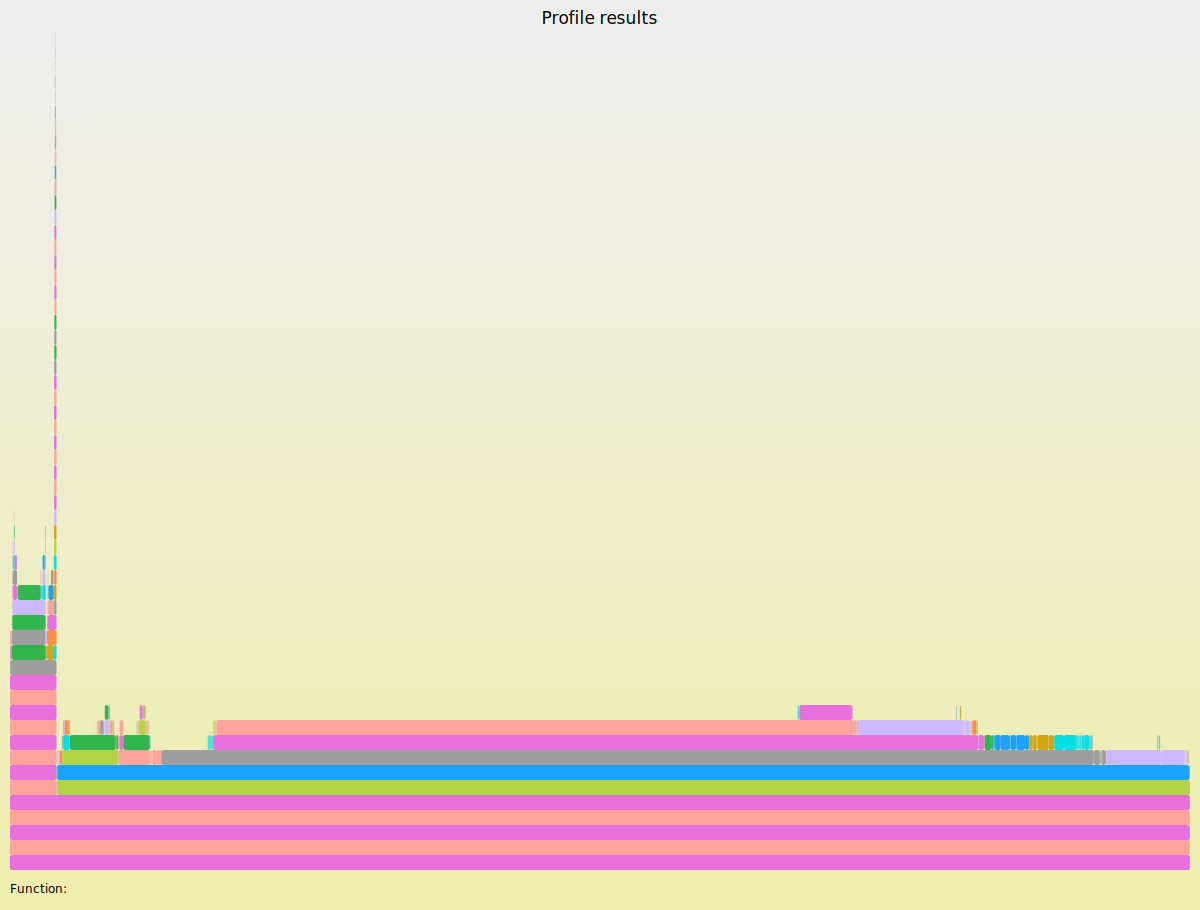

In [19]:
using ProfileView
ProfileView.view()
